# Body Fat Data Project

The goal is to come up with a simple, precise and accurate way of determining body fat percentage of males based on readily available clinical measurements.

## Data Cleaning

In this step, we want to check duplicate data, fix and amend badly-formatted, incorrect and amend incomplete data from original file.

In [26]:
# import necessary modules
import itertools 
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [27]:
# load data and set IDNO as index
dat = pd.read_csv('BodyFat.csv', index_col=0)
dat.head()

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
IDNO,,,,,,,,,,,,,,,,
1,12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [28]:
# check for duplicate data
dat[dat.duplicated(keep=False)]

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
IDNO,,,,,,,,,,,,,,,,


In [29]:
# check for missing data
dat.isnull().sum()

BODYFAT      0
DENSITY      0
AGE          0
WEIGHT       0
HEIGHT       0
ADIPOSITY    0
NECK         0
CHEST        0
ABDOMEN      0
HIP          0
THIGH        0
KNEE         0
ANKLE        0
BICEPS       0
FOREARM      0
WRIST        0
dtype: int64

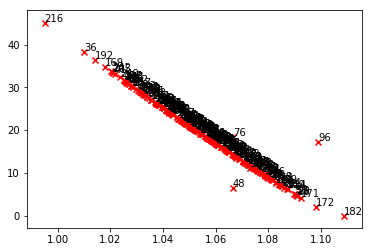

In [30]:
# check the incorrect data points
## relationship of BODYFAT and DENSITY
for i,index in enumerate(dat.index):
    x = dat.DENSITY.values[i]
    y = dat.BODYFAT.values[i]
    plt.scatter(x, y, marker = 'x', color = 'red')
    plt.text(x, y + 0.3, index)
plt.show()

Because we don't know either bodyfat or density is incorrect, we delete these outliers (182). The bodyfat of IDNO.182 is 0 and this is impossible. Also, If we want to impute the bodyfat by using density information, the value of bodyfat will be negative. 

In [31]:
dat.loc[[182]]
dat = dat.drop(index=[182], columns='DENSITY')

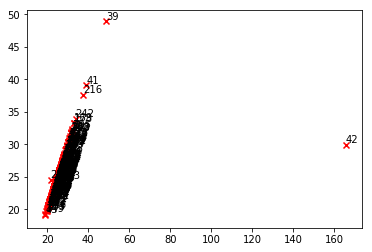

In [32]:
## relationship of ADIPOSITY, WEIGHT, HEIGHT
for i, index in enumerate(dat.index):
    x = dat.WEIGHT.values[i]/(dat.HEIGHT.values[i])**2 * 703
    y = dat.ADIPOSITY.values[i]
    plt.scatter(x, y ,marker='x', color='red')
    plt.text(x, y+0.3, index)
plt.show()

The plot above shows that INDO.42 is an strong influential point. If we dig in the data point, we will notice the height of this guy is 29.5 inch but the weight is 205 lbs. The BMI will be 165.6, which is impossible.

In [33]:
dat.loc[[42]]
dat = dat.drop(index=42)

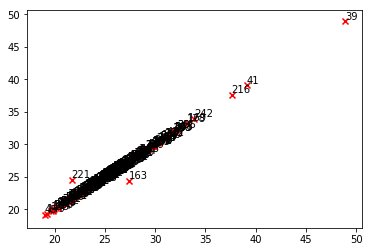

In [34]:
# recheck
for i, index in enumerate(dat.index):
    x = dat.WEIGHT.values[i]/(dat.HEIGHT.values[i])**2 * 703
    y = dat.ADIPOSITY.values[i]
    plt.scatter(x, y ,marker='x', color='red')
    plt.text(x, y+0.3, index)
plt.show()

# Best subset selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. This results in $2^n$ possibilities as this is a power set problem. In our case there are $2^{14} = 16384$ possible combinations

In [173]:
dat.shape

(250, 15)

# Algorithm
Let $M_0$ denote the null model which contains no predictors, this model simply predicts the sample mean of each observation

- For $k=1,2,...,n$
    - Fit all $n \choose k$ models that contain exactly k predictors
    - Pick the best among these $n \choose k$ models, and call it $M_k$. Here the best is defined as having the smallest RSS, or an equivalent measure
- Select the single best model among $M_0,M_1,...,M_n$ using cross validated predicton error, $C_p$, BIC, AIC, adjusted $R^2$ or any other method.

# Helper function for fitting linear regression

In [37]:
def fit_linear_reg(X,Y):
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y, model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

# Implementing Best subset selection

In [35]:
# Initialize variables
Y = dat.BODYFAT
X = dat.drop(columns = 'BODYFAT', axis = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
k = 14

In [175]:
# Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
RSS_list, R_squared_list, feature_list = [], [], []
numb_features = []

# Looping over k = 1 to k = 14 features in X 
for k in tnrange(1, len(X.columns) + 1, desc = 'Loop...'):
    # Looping over all possible combinations: from 14 choose k
    for combo in itertools.combinations(X.columns, k):
        tmp = fit_linear_reg(X[list(combo)], Y)
        RSS_list.append(tmp[0])
        R_squared_list.append(tmp[1])
        feature_list.append(combo)
        numb_features.append(len(combo))
        
# Store in DataFrame
res = pd.DataFrame({'numb_features': numb_features, 'RSS': RSS_list, 
                    'R_squared': R_squared_list, 'features': feature_list})

# Finding the best subsets for each number of features

Using the smallest RSS value

In [178]:
res_min = res[res.groupby('numb_features')['RSS'].transform(min) == res['RSS']]
display(res_min.head(5))

,numb_features,RSS,R_squared,features
6,1,5029.782963,0.654485,"(ABDOMEN,)"
31,2,4172.898784,0.713347,"(WEIGHT, ABDOMEN)"
227,3,4049.773335,0.721805,"(WEIGHT, ABDOMEN, WRIST)"
939,4,3943.098639,0.729133,"(WEIGHT, ABDOMEN, FOREARM, WRIST)"
2518,5,3906.621396,0.731639,"(WEIGHT, NECK, ABDOMEN, FOREARM, WRIST)"


# Adding columns to the data frame with RSS and R squared values of the bset subset

In [133]:
res['min_RSS'] = res.groupby('numb_features')['RSS'].transform(min)
res['max_R_squared'] = res.groupby('numb_features')['R_squared'].transform(max)
res.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,13168.554590,0.085225,"(AGE,)",4943.606721,0.656584
1,1,9093.247868,0.368323,"(WEIGHT,)",4943.606721,0.656584
2,1,14384.206562,0.000778,"(HEIGHT,)",4943.606721,0.656584
3,1,6949.077601,0.517271,"(ADIPOSITY,)",4943.606721,0.656584
4,1,10958.560313,0.238746,"(NECK,)",4943.606721,0.656584


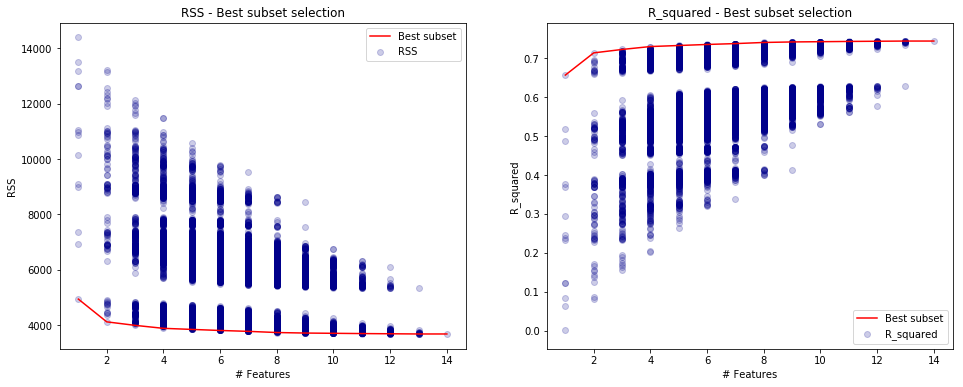

In [135]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1,2,1)
ax.scatter(res.numb_features, res.RSS, alpha = .2, color = 'darkblue')
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(res.numb_features, res.min_RSS, color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.scatter(res.numb_features, res.R_squared, alpha = .2, color = 'darkblue')
ax.set_xlabel('# Features')
ax.set_ylabel('R_squared')
ax.set_title('R_squared - Best subset selection')
ax.plot(res.numb_features, res.max_R_squared, color = 'r', label = 'Best subset')
ax.legend()

plt.show()

# Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large $n$ due to the $2^n$ complexity.
## Algorithm
Let $M_0$ denote the null model which contains no predictors
- For $k=1,2,...,n-1$
    - Consider all $n-k$ models that augment the predictors in $M_k$ with one additional predictor
    - CHoose the best among these $n-k$ models, and call it $M_{k+1}$ 
- Select the single best model among $M_0, M_1,...,M_n$ using cross validated prediction error, $C_p$, AIC, BIC, adjusted $R^2$ or any other method.

In [38]:
remaining_features = list(X_train.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf]
features_list = dict()

for i in range(1, k+1):
    best_RSS = np.inf
    for combo in itertools.combinations(remaining_features, 1):
        RSS = fit_linear_reg(X_train[list(combo) + features], Y_train) # Store temp result
        if RSS[0] < best_RSS:
            best_RSS = RSS[0]
            best_R_squared = RSS[1]
            best_feature = combo[0]
            
    # Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    # Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()


## Displaying results of the first 4 steps

In [39]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', "RSS")
display([(i, features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['ABDOMEN'], 3976.0),
 (2, ['ABDOMEN', 'WEIGHT'], 3272.0),
 (3, ['ABDOMEN', 'WEIGHT', 'WRIST'], 3193.0),
 (4, ['ABDOMEN', 'WEIGHT', 'WRIST', 'FOREARM'], 3077.0)]

# Comparing models: Mallow's $C_p$, AIC, BIC and adjusted $R^2$
The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and $R^2$ may not be used for selecting the best model unless we adjust for this underestimation.
## Mallow's $C_p$
Mallow's $C_p$ is defined as:$$C_p=\frac{1}{m}(RSS+2d\hat{\sigma}^2)$$
where $\hat{\sigma}^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Typically, $\hat{\sigma}^2$ is estimated using the full model containing all predictors.

Essentially, the $C_p$ statistic adds a penalty of $2d\hat{\sigma}^2$ to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. The penalty increases as the number of predictos in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. WE need choose the model with the smallest $C_p$.
## Akaike's Information Criteria (AIC)
The AIC criterion is defined as:$$AIC = \frac{1}{m\hat{\sigma}^2}(RSS+2d\hat{\sigma}^2)$$
## Bayesian Information Criteria (BIC)
The BIC criterion is defined as:$$BIC = \frac{1}{m\hat{\sigma}^2}(RSS+log(m)\hat{\sigma}^2)$$
## Adjusted $R^2$
Since the $R^2$ always increases as more variables are added, the adjusted $R^2$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model, additional noise variables will lead to a very small decrease in RSS, but an increase in k and hence will decrease the adjusted $R^2$. In effect, we pay a price for the inclusion of unnecessary variables in the model.
$$R_{adj}^2=1-(1-R^2)\frac{m-1}{m-k-1}$$

In [40]:
# Combing forward stepwise results into a new DataFrame
forward_res = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
forward_res['numb_features'] = forward_res.index
m = len(Y)
p = 14
# Estimation of sigma2
hat_sigma_squared = (1/(m-p-1)) * min(forward_res['RSS'])
forward_res['C_p'] = (1/m) * (forward_res['RSS'] + 2 * forward_res['numb_features'] * hat_sigma_squared)
forward_res['AIC'] = (1/(m*hat_sigma_squared)) * (forward_res['RSS'] + 2 * forward_res['numb_features'] * hat_sigma_squared)
forward_res['BIC'] = (1/(m*hat_sigma_squared)) * (forward_res['RSS'] + np.log(m) * forward_res['numb_features'] * hat_sigma_squared)
forward_res['R_squared_adj'] = 1 - ((1 - forward_res['R_squared']) * (m - 1) / (m - forward_res['numb_features'] - 1))
forward_res

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[ABDOMEN],3975.521915,0.659770,1,15.998766,1.323875,1.337961,0.658398
2,"[ABDOMEN, WEIGHT]",3271.812499,0.719994,2,13.280607,1.098951,1.127123,0.717727
3,"[ABDOMEN, WEIGHT, WRIST]",3192.974494,0.726741,3,13.061933,1.080856,1.123114,0.723409
4,"[ABDOMEN, WEIGHT, WRIST, FOREARM]",3077.218319,0.736648,4,12.695587,1.050542,1.106885,0.732348
5,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK]",3034.185987,0.740331,5,12.620136,1.044298,1.114728,0.735010
6,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK, BICEPS]",2997.559029,0.743465,6,12.570306,1.040175,1.124690,0.737131
7,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK, BICEPS...",2961.890859,0.746518,7,12.524312,1.036369,1.134970,0.739186
8,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK, BICEPS...",2946.096444,0.747870,8,12.557813,1.039141,1.151828,0.739500
9,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK, BICEPS...",2934.613534,0.748852,9,12.608560,1.043340,1.170113,0.739434
10,"[ABDOMEN, WEIGHT, WRIST, FOREARM, NECK, BICEPS...",2925.053540,0.749670,10,12.666998,1.048176,1.189035,0.739196


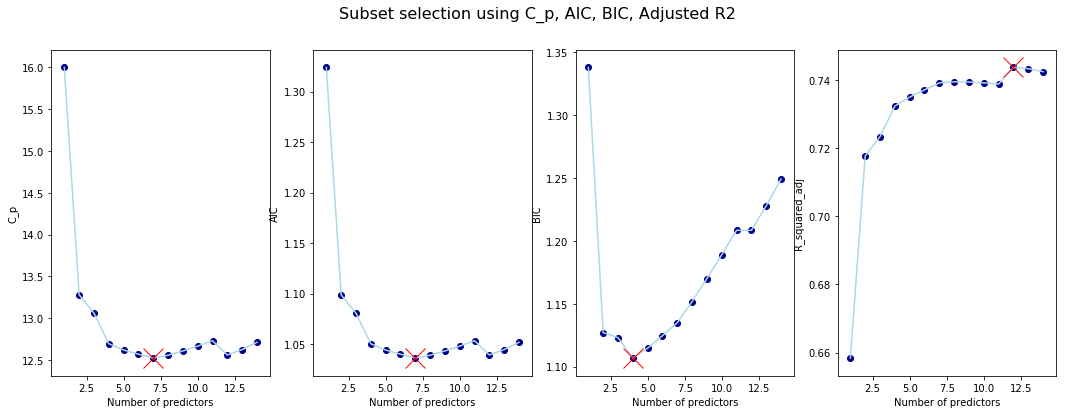

In [41]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(forward_res['numb_features'],forward_res[v], color = 'lightblue')
    ax.scatter(forward_res['numb_features'],forward_res[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(forward_res[v].idxmax(),forward_res[v].max(), marker = 'x', markersize = 20, color = 'red')
    else:
        ax.plot(forward_res[v].idxmin(),forward_res[v].min(), marker = 'x', markersize = 20, color = 'red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

We want to apply BIC criterion to select the simplest model, which includes 4 predictors (ABDOMEN, WEIGHT, WRIST, FOREARM). But the p-value of FOREARM in the model is relatively larger than 0.05, which is insignificant. Hence, we can use ANOVA test to compare with the 3-predictor (ABDOMEN, WEIGHT, WRIST) model. The result shows that there is no significant evidence to conclude that the two models are different. Thus, we choose the simpler model (3-predictor) and then do ANOVA test with 2-predictor model as well. We can conclude that the two models are different at $\alpha = 0.05$ significant level. But in this case, we notice that people only care about the description of body fat percentage rather than the exact value of body fat percentage . 


| Description | Men |
| --- | --- |
| Essential fat | 3-5\% |
| Athletes | 6-13\% |
| Fitness | 14-17\% |
|Average|18-24\%|
|Obese|25\%+|

In [108]:
mod4 = sm.OLS(Y_train, sm.add_constant(X_train[['ABDOMEN', 'WEIGHT', 'WRIST', 'FOREARM']])).fit()
print(mod4.pvalues)
mod3 = sm.OLS(Y_train, sm.add_constant(X_train[['ABDOMEN', 'WEIGHT', 'WRIST']])).fit()
mod2 = sm.OLS(Y_train, sm.add_constant(X_train[['ABDOMEN', 'WEIGHT']])).fit()
mod1 = sm.OLS(Y_train, sm.add_constant(X_train.ABDOMEN)).fit()

const      1.419609e-05
ABDOMEN    1.070929e-37
WEIGHT     9.016456e-07
WRIST      3.085878e-03
FOREARM    7.362386e-03
dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [109]:
from statsmodels.stats.anova import anova_lm
anovaRes = anova_lm(mod3, mod4)
print(anovaRes)
anovaRes = anova_lm(mod2, mod3)
print(anovaRes)

   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0     196.0  3192.974494      0.0         NaN       NaN       NaN
1     195.0  3077.218319      1.0  115.756174  7.335344  0.007362
   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0     197.0  3271.812499      0.0        NaN       NaN       NaN
1     196.0  3192.974494      1.0  78.838005  4.839453  0.028985


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [116]:
pred_mod4 = mod4.predict(sm.add_constant(X_test[['ABDOMEN', 'WEIGHT', 'WRIST', 'FOREARM']]))
pred_mod3 = mod3.predict(sm.add_constant(X_test[['ABDOMEN', 'WEIGHT', 'WRIST']]))
pred_mod2 = mod2.predict(sm.add_constant(X_test[['ABDOMEN', 'WEIGHT']]))
pred_mod1 = mod1.predict(sm.add_constant(X_test[['ABDOMEN']]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [117]:
pred = pd.DataFrame({'mod1': pred_mod1, 'mod2': pred_mod2, 'mod3': pred_mod3, 'mod4': pred_mod4, 'real': Y_test})
c = pd.cut(
    pred.stack(),
    [3, 24.99, np.inf],
    labels=['average', 'obese'])
pred = pred.join(c.unstack().add_suffix('_cat'))
pred

,mod1,mod2,mod3,mod4,real,mod1_cat,mod2_cat,mod3_cat,mod4_cat,real_cat
IDNO,,,,,,,,,,
129,19.743585,18.195481,18.699213,19.047959,20.4,average,average,average,average,average
190,24.154003,26.129999,25.922663,26.213713,23.8,average,obese,obese,obese,average
25,9.891742,8.280958,8.307455,8.479609,14.2,average,average,average,average,average
209,14.244882,13.872389,13.972297,13.766300,10.1,average,average,average,average,average
238,31.371050,32.831088,33.461453,33.483052,26.4,obese,obese,obese,obese,obese
32,14.588551,14.447662,14.331772,13.410830,6.5,average,average,average,average,average
21,21.118260,22.169180,21.954209,22.955541,19.0,average,average,average,average,average
205,31.428328,32.395602,34.242061,35.288853,33.4,obese,obese,obese,obese,obese
199,10.865471,7.629555,7.197753,7.840614,7.3,average,average,average,average,average


By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$. Thus in binary classfication, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.

We can see from the matrix that the model1~model4 behave similar when distinguishing between average males and obese males. Thus we can make the model as simple as model1.

The selected model is $$BodyFat = -33.8+0.5728 \times ABDOMEN$$


In [124]:
from sklearn.metrics import confusion_matrix
# this produces a 2*2 numpy array (matrix)
print(confusion_matrix(pred.real_cat, pred.mod4_cat))

[[35  3]
 [ 4  8]]


- True Positives (TP): we correctly predicted that they are obese
    - 8
- True Negatives (TN): we correctly predicted that they are not obese
    - 35
- False Positives (FP): we incorrectly predicted that they are obese
    - 3
- False Negatives (FN): we incorrectly predicted that they are not obese
    - 4

In [122]:
confusion_matrix(pred.real_cat, pred.mod3_cat)

array([[34,  4],
       [ 4,  8]])

In [119]:
confusion_matrix(pred.real_cat, pred.mod2_cat)

array([[35,  3],
       [ 5,  7]])

In [120]:
confusion_matrix(pred.real_cat, pred.mod1_cat)

array([[34,  4],
       [ 7,  5]])

In [123]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BODYFAT   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     384.0
Date:                Fri, 01 Feb 2019   Prob (F-statistic):           3.07e-48
Time:                        00:57:39   Log-Likelihood:                -582.75
No. Observations:                 200   AIC:                             1169.
Df Residuals:                     198   BIC:                             1176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.8115      2.716    -12.450      0.000     -39.167     -28.456
ABDOMEN        0.5728      0.029     19.595      0.000       0.515       0.630
==============================================================================
Omnibus:                        2.232   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                1.841
Skew:                          -0.180   Prob(JB):                        0.398
Kurtosis:                       3.302   Cond. No.                         796.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""